In [1]:
import requests, re, json
import scrape_utils as su

proxy = open('proxy_ip.txt', 'r').read().strip()

s = requests.Session()
s.proxies.update(su.proxy_dict(proxy))
s.headers.update(json.loads(open('headers.json', 'r').read()))
su.verify_session_proxy(s)

base_url = 'https://www.ulife.utoronto.ca'
start_page = base_url + '/organizations'

soup = su.visit_uri(start_page, s)
listing_urls = [base_url + link['href'] for link in soup.select('#main.internal p .alphaLinks')]

Proxy IP: OK


In [5]:
listing_pages = {}
wait_element = '#main.internal .listingNav .rowCount'
base_listing_uri = start_page + '/list/alpha/{}/page/{}/type/all'

for listing in listing_urls:
    key = listing.split('/')[-1]
    try:
        soup = su.validate_and_cache_page(s, listing, wait_element)
        nav_text = soup.select_one(wait_element).text.strip()
        res_count = int(re.search('of (\d+)',nav_text).group(1))
        max_page = -(-res_count // 25)
        listing_pages[key] = {
            'results': res_count,
            'pages': [base_listing_uri.format(key, i + 1) for i in range(max_page)]
        }
    except Exception as e:
        print('ERR!', e) 

In [8]:
org_pages = {}
wait_element = '#main.internal .manageTable .listing li a'
for key in listing_pages:
    for url in listing_pages[key]['pages']:
        try:
            soup = su.validate_and_cache_page(s, url, wait_element)
            links = soup.select(wait_element)
            for link in links:
                org_pages[link.text.strip()] = base_url + link['href']
        except Exception as e:
            print('ERR!', e)

print('\nCaptured', len(org_pages), 'organizarion URIs')

<C> 49baae882a8b98ffa02c66d863d9101e.html
Captured 1401 organizarion URIs


In [129]:
import pandas as pd

df = pd.DataFrame()

wait_element = '#main.internal .groupInfo'

css = {
    'org_name': '#main.internal .detailHeading',
    'description': '#main.internal h1 ~div p',
    'contacts@dt': '#main.internal .groupInfo .thirdCol:nth-of-type(1) dl',
    'org_details@dt': '#main.internal .groupInfo .thirdCol:nth-of-type(2) dl',
    'execs@dt': '#main.internal .groupInfo .thirdCol:nth-of-type(3) dl',
}


for key in org_pages:
    url = org_pages[key]
    try:
        soup = su.validate_and_cache_page(s, url, wait_element)
        data = {}
        exec_count = 0
        for s in css: 
            if '@' in s:
                col, sub_sel = s.split('@')
                dl_value = []
                for child in soup.select_one(css[s]).findChildren():
                    if child.name == 'dt':
                        if len(dl_value) > 0:
                            if col == 'execs':
                                exec_count += 1
                                member, position = (dl_key, dl_value)
                                data[f'group_leader_{exec_count:02}'] = f'("{position}", "{member}")'
                            else:
                                dl_value = dl_value[0] if (type(dl_value) is list) and (len(dl_value) == 1) else str(dl_value)
                                data[dl_key.lower().replace(' ','_')] = dl_value
                            dl_value = []
                        dl_key = child.text    
                    elif child.name == 'dd':
                        if dl_key in ['Website', 'Group Email Address']:
                            value = child.a['href'] if child.a else ''
                            dl_value.append(value)
                        else:
                            dl_value.append(child.text)
            else:
                data[s] = soup.select_one(css[s]).text.strip()
        data['number_of_leaders'] = exec_count
        data['page_uri'] = url
        df = df.append(data, ignore_index=True)

    except Exception as e:
        print('ERR!', e)
#         raise e
recorded_cols = set(df.columns)
print('\nCached', df.shape[0], 'organizarion URIs')

<C> 8b6ffabeac1f524acd3d1c0140672dae.html
Cached 1401 organizarion URIs


In [138]:
col_order = ['campus_association','org_name','organization_type','areas_of_interest','description',
 'renewal_date','group_email_address','mailing_address','primary_contact','secondary_contact',
 'telephone','social','website', 'number_of_leaders']
group_leader_cols = sorted([col for col in df.columns if 'group_leader' in col])
col_order = col_order + group_leader_cols + ['page_uri']
assert len(recorded_cols - set(col_order)) == 0

df = df.reindex(col_order, axis=1)

print(df.shape)
show_cols = ['campus_association','org_name','organization_type','areas_of_interest','description','page_uri']
df.head()[show_cols]

(1401, 43)


,campus_association,org_name,organization_type,areas_of_interest,description,page_uri
0,Scarborough (UTSC),A.Taj Aerospace medicine (A.Taj),Recognized Student Group,"['Academic', 'Global Interests', 'Media']",In my opinion human race is really behind in research related to our health in space as we are mainly focusing on human health on earth.\nOur association will mainly focus on human health in space...,https://www.ulife.utoronto.ca/organizations/view/id/128278
1,St. George,Academia Musica Historica (AMH),Recognized Student Group,"['Academic', 'Arts', 'Social']",The purpose of ‘Academia Musica Historica’ is aimed at bringing together students with a common interest in historical music here at the University of Toronto. As a group we aim to provide opportu...,https://www.ulife.utoronto.ca/organizations/view/id/128422
2,St. George,Academic Alliance at the University of Toronto,Recognized Student Group,"['Academic', 'Community Service', 'Social Justice/Advocacy']",Academic Alliance at the University of Toronto aims to provide immediate front-line peer support to students who are struggling academically at the University of Toronto. We offer a wide range of ...,https://www.ulife.utoronto.ca/organizations/view/id/128050
3,St. George,Academic Trivia Club,Recognized Student Group,"['Academic', 'Hobby and Leisure']",The University of Toronto Academic Trivia Club provides a fun and casual forum for students and members of the university community in general to play and practice quizbowl -- a team-based trivia ...,https://www.ulife.utoronto.ca/organizations/view/id/3070
4,Mississauga (UTM),Accounting Association (UTMAA),Recognized Student Group,"['Academic', 'Leadership', 'Work and Career Development']",The Board of Ambassadors (BoA) is comprised of top business students from over 20 university and college campuses across Ontario and acts as an advisory and advocacy group for the Chartered Profes...,https://www.ulife.utoronto.ca/organizations/view/id/128514


In [112]:
df.areas_of_interest.value_counts().head()

Academic                                                                67
['Academic', 'Leadership', 'Work and Career Development']               50
['Community Service', 'Global Interests', 'Social Justice/Advocacy']    32
Student Governments Unions and Councils                                 31
['Academic', 'Social', 'Work and Career Development']                   25
Name: areas_of_interest, dtype: int64

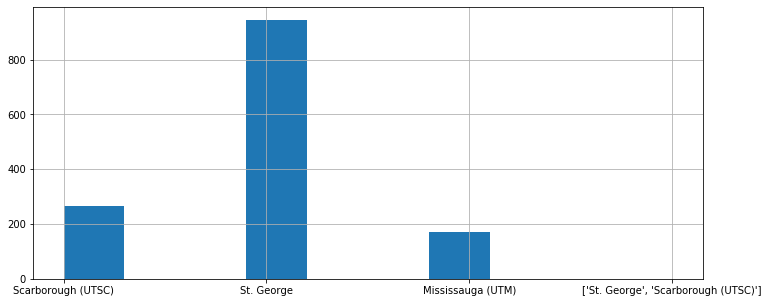

In [128]:
df.campus_association.hist(figsize=(12,5));

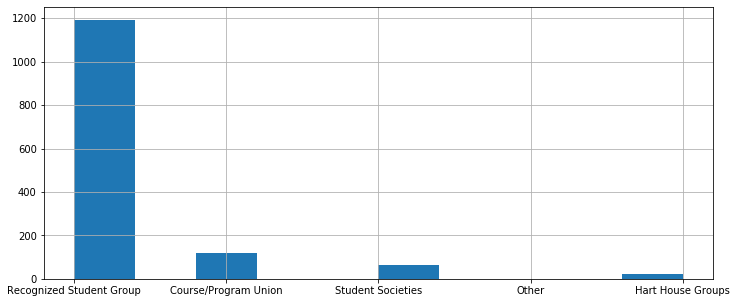

In [127]:
df.organization_type.hist(figsize=(12,5));

In [96]:
df[df.campus_association=='[\'St. George\', \'Scarborough (UTSC)\']'].page_uri

305    https://www.ulife.utoronto.ca/organizations/view/id/2817
Name: page_uri, dtype: object

In [139]:
export_file = 'datasets/edu/uoft_sudent_organizations.tsv'
df.to_csv(export_file, sep='\t', index=False)
!ls -lh {export_file}

-rw-r--r--  1 onzo  staff   1.2M 25 Feb 15:19 datasets/edu/uoft_sudent_organizations.tsv


In [140]:
from excel_helper import xlsx_exporter

xlsx_exporter({'student_orgs': df}, 'datasets/edu/uoft_sudent_organizations_cleaned.xlsx')

Loading student_orgs

Saving Excel file...
